In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from sklearn import ensemble, tree, svm
import scipy as sp
import xgboost as xgb

In [57]:
# Import data
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)

#get info

def get_details(data):
    skew= data.skew()
    corr = data.corr()['SalePrice']

    nulls = data.apply(lambda x: x.isnull().sum())
    nulls_perc = data.apply(lambda x: x.isnull().sum()/data.shape[0]*100)
    unique = data.apply(lambda x: [x.unique()])

    details = pd.concat([skew, corr, nulls, nulls_perc, unique], axis=1, sort=False)
    details.columns = ['skew', 'corr', 'nulls', 'nulls_perc', 'unique']
    
    return details
    
def get_features(model, x, y):
    
    model.fit(x, y)
    feature_importance = {}

    for i, col in enumerate(x.columns):
        feature_importance[col] = model.feature_importances_[i]

    return {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1],reverse=True)}

def lift_table(actual, pred, weight=None, n=10, xlab='Predicted Decile', MyTitle='Model Performance Lift Chart'):

    if weight is None:
        weight=np.ones((1,len(actual)))

    pdf= pd.DataFrame(sp.vstack([actual,pred,weight]).T,columns=['Actual','Predicted','Weight'],)
    pdf= pdf.sort_values(by='Predicted')

    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'].astype(float))
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])

    TotalWeight = sum(pdf['Weight'])

    pdf['PredictedDecile'] = np.round(pdf['CummulativeWeight']*n /TotalWeight + 0.5,decimals=0)
    pdf['PredictedDecile'][pdf['PredictedDecile'] < 1.0] = 1.0
    pdf['PredictedDecile'][pdf['PredictedDecile'] > n] = n
    pdf['WeightedPrediction'] = pdf['Predicted']*pdf['Weight']
    pdf['WeightedActual'] = pdf['Actual']*pdf['Weight']

    lift_df = pdf.groupby('PredictedDecile').agg({'WeightedPrediction': np.sum,'Weight':np.sum,'WeightedActual':np.sum,'PredictedDecile':np.size})

    lift_df['AveragePrediction'] = lift_df['WeightedPrediction']/lift_df['Weight']
    lift_df['AverageActual'] = lift_df['WeightedActual']/lift_df['Weight']
    lift_df['AverageError'] = lift_df['AverageActual']/lift_df['AveragePrediction']

    return lift_df

def plot_lift(lift_df):

    n=lift_df.shape[0]
    d = pd.DataFrame(lift_df.index)
    p = list(lift_df['AveragePrediction'])#p = list(lift_df['AveragePredictionBalanced'])
    a = list(lift_df['AverageActual'])

    mean_actual=np.mean(a)
    p.reverse()
    a.reverse()

    lift=a[0]/mean_actual

    plt.plot(d,p,label='Predicted',color='blue',marker='o')
    plt.plot(d,a,label='Actual',color='red',marker='d')
    plt.plot(range(1,n+1),[mean_actual]*n,'--',label='Mean',color='k',marker=None)
    plt.legend(['Predicted','Actual','Mean'])
    plt.xlabel('decile')
    plt.ylabel('Actual vs. Predicted')
    plt.text(n-2,1.2*mean_actual, 'lift = {0:.2f} '.format(lift))
    plt.show()

def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

def RSS(actual, predicted):
    return np.sum(np.square(actual - predicted))

cat = train.select_dtypes(include=['O']).columns
cont = train.select_dtypes(exclude=['O']).columns

details = get_details(train[cont]).sort_values('corr', ascending = False).iloc[1:].head(12)

train = train.loc[train.GrLivArea <= 4500]
train = train.loc[train.TotalBsmtSF < 6000]
train = train.loc[train['1stFlrSF'] < 4000]

data = pd.concat([train, test], sort=False).reset_index(drop=True)

#impute NaN

data.loc[data.PoolQC.isnull() & data.PoolArea == 0, 'PoolQC'] = 'NA'
data.loc[data.MiscFeature.isnull() & (data.MiscVal == 0), 'MiscFeature'] = 'NA'
data.loc[data.Alley.isnull(), 'Alley'] = 'NA'
data.loc[data.Fence.isnull(), 'Fence'] = 'NA'
data.loc[data.FireplaceQu.isnull(), 'FireplaceQu'] = 'NA'
data.loc[data.LotFrontage.isnull(), 'LotFrontage'] = 0

fill = pd.Series([data[c].value_counts().index[0] for c in data[cat]],
            index=data[cat].columns)

data[cat] = data[cat].fillna(fill)

details = get_details(data)

fill = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

for i in fill:
    data.loc[data[i].isnull(), i] = data.groupby(['OverallQual', 'Neighborhood'])[i].transform(lambda x: x.fillna(x.mean()))
    
fill = ['BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageYrBlt']

for i in fill:
    data.loc[data[i].isnull(), i] = data.groupby(['OverallQual', 'Neighborhood'])[i].transform(lambda x: x.fillna(x.median()))
    
data.loc[data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = data.GarageYrBlt.median()
    
data = data.drop(['Utilities'], axis = 1)
    
cat = cat.to_list()
cat.remove('Utilities')

dummy = pd.get_dummies(data[cat])

data = pd.concat([data, dummy], axis =1)
data = data.drop(cat, axis = 1)

data.loc[data['SalePrice'].isnull(), 'SalePrice'] = 0

details = get_details(data[cont]).sort_values('skew', ascending = False)

no_log = data

cols = details.loc[abs(details['skew']) > 0.7].index.to_list()
cols.remove('SalePrice')

# Boxcox

l_opt = {}
for i in cols:
    data.loc[:, i], l_opt[i] = boxcox(data.loc[:, i] + 1)

data = data.drop('MiscVal', axis = 1)
data_copy = data

#go back to train and test
train  = data.loc[data.SalePrice > 0,]
test = data.loc[data.SalePrice == 0,]

x = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

#pvalues

results = sm.OLS(y, x).fit()
pValues = results.pvalues

pValues = list(pValues[pValues<0.05].index)
linear_x = x[pValues]

r2 = pd.DataFrame(columns= ['r2_train', 'r2_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test'])

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

lX_train = linear_x.iloc[X_train.index]
lX_test = linear_x.iloc[X_test.index]

#no transformation data
train2  = no_log.loc[no_log.SalePrice > 0,]

x2 = train2.drop('SalePrice', axis = 1)

X2_train = x2.iloc[X_train.index]
X2_test = x2.iloc[X_test.index]

In [62]:
# LINEAR MODEL

lm = LinearRegression()
lm.fit(lX_train, Y_train)

lm_train = lm.predict(lX_train)
lm_test = lm.predict(lX_test)

r2.loc['Linear'] = pd.Series({
                        'r2_train': lm.score(lX_train, Y_train),
                        'r2_test': lm.score(lX_test, Y_test), 
                        'MSE_train': mse(Y_train, lm_train), 
                        'MSE_test': mse(Y_test, lm_test),
                        'MAE_train': mae(Y_train, lm_train), 
                        'MAE_test': mae(Y_test, lm_test)
                    })

# r2.loc['Linear', 'MSE'] = mse(Y_test, lm_pred)
# r2.loc['Linear', 'MAE'] = mae(Y_test, lm_pred)
r2

,r2_train,r2_test,MSE_train,MSE_test,MAE_train,MAE_test
Linear,0.862228,0.843184,9.044774e+08,8.330910e+08,20198.614094,21199.267657


{'alpha': 0.2, 'normalize': True, 'random_state': 42}
0.8739028965228286
0.9209303658810409
0.9028987158275039


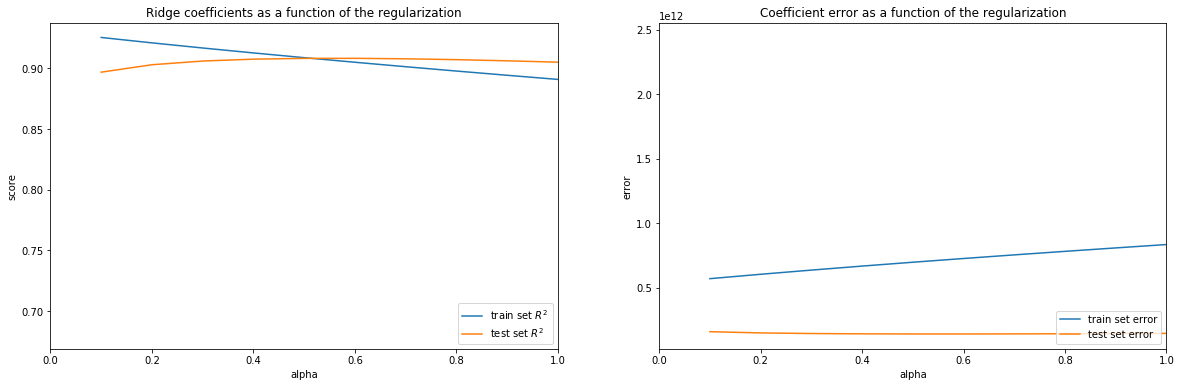

,r2_train,r2_test,MSE_train,MSE_test,MAE_train,MAE_test
Linear,0.862228,0.843184,9.044774e+08,8.330910e+08,20198.614094,21199.267657
Ridge,0.920930,0.902899,5.190947e+08,5.158543e+08,14759.202367,15455.445542
Lasso,0.903671,0.907670,6.324004e+08,4.905077e+08,16276.156004,15746.920270
ElasticNet,0.914445,0.905326,5.616724e+08,5.029603e+08,15529.644301,15661.559294
Tree,0.915323,0.821774,5.559042e+08,9.468328e+08,16026.048282,21898.039481
XGB,0.975217,0.817783,1.627040e+08,9.680330e+08,9576.023474,20537.184249


In [147]:
# RIDGE

#if rss train > rss test, good. if test error > train rss, overfit
#RSS for train as well

alphaRange = np.linspace(0.1, 10, 100)

ridge = Ridge(normalize= True, random_state = 42)

parameters = [{'normalize' : [True], 'alpha': alphaRange, 'random_state': [42]}]
ridgeCV = GridSearchCV(ridge, parameters, cv=5)
ridgeCV.fit(X_train, Y_train)
print(ridgeCV.best_params_)
print(ridgeCV.best_score_)
print(ridgeCV.score(X_train, Y_train))
print(ridgeCV.score(X_test, Y_test))

train_R2 = []
test_R2  = []
e_train = []
e_test = []

for alpha in alphaRange:
    ridge.set_params(alpha=alpha)  
    ridge.fit(X_train, Y_train)
    train_R2.append(ridge.score(X_train, Y_train))
    test_R2.append(ridge.score(X_test, Y_test))
    
    y_val = ridge.predict(X_train)
    y_pred = ridge.predict(X_test)
    e_train.append(RSS(Y_train, y_val))
    e_test.append(RSS(Y_test, y_pred))

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(121)
ax1.plot(alphaRange, train_R2, label=r'train set $R^2$')
ax1.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.xlabel('alpha')
plt.ylabel('score')
ax1.set_xlim([0, 1])
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(loc=4)

ax2 = plt.subplot(122)
ax2.plot(alphaRange, e_train, label=r'train set error')
ax2.plot(alphaRange, e_test, label=r'test set error')
plt.xlabel('alpha')
plt.ylabel('error')
ax2.set_xlim([0, 1])
plt.title('Coefficient error as a function of the regularization')
plt.legend(loc=4)

plt.show()

ridge.set_params(alpha = ridgeCV.best_params_['alpha'])
ridge.fit(X_train, Y_train)

# ridge_pred = ridge.predict(X_test)
ridge_train = ridge.predict(X_train)
ridge_test = ridge.predict(X_test)

r2.loc['Ridge'] = pd.Series({
                        'r2_train': ridge.score(X_train, Y_train),
                        'r2_test': ridge.score(X_test, Y_test), 
                        'MSE_train': mse(Y_train, ridge_train), 
                        'MSE_test': mse(Y_test, ridge_test),
                        'MAE_train': mae(Y_train, ridge_train), 
                        'MAE_test': mae(Y_test, ridge_test)
                    })

r2

{'alpha': 24.484367468222267, 'normalize': True, 'random_state': 42}
-17756.762603559302
-15635.427218427008
-15678.940860632334


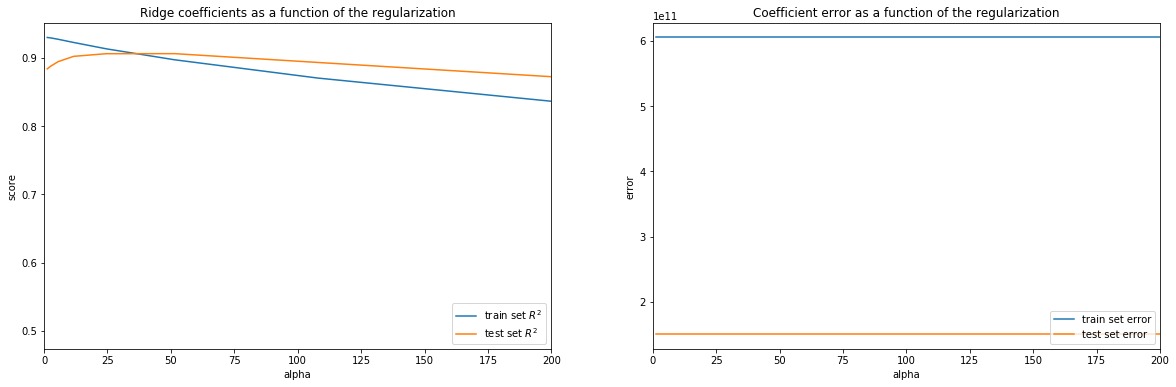

,r2_train,r2_test,MSE_train,MSE_test,MAE_train,MAE_test
Linear,0.862228,0.843184,9.044774e+08,8.330910e+08,20198.614094,21199.267657
Ridge,0.920930,0.902899,5.190947e+08,5.158543e+08,14759.202367,15455.445542
Lasso,0.912954,0.905783,5.714580e+08,5.005338e+08,15635.427218,15678.940861
ElasticNet,0.914445,0.905326,5.616724e+08,5.029603e+08,15529.644301,15661.559294
Tree,0.915323,0.821774,5.559042e+08,9.468328e+08,16026.048282,21898.039481
XGB,0.975217,0.817783,1.627040e+08,9.680330e+08,9576.023474,20537.184249


In [150]:
# LASSO

lasso = Lasso(normalize= True, random_state = 42)

alphaRange = np.logspace(0.1, 3, 10)

parameters = {'normalize': [True], 'alpha': alphaRange, 'random_state': [42]}
lassoCV = GridSearchCV(lasso, parameters, scoring ='neg_mean_absolute_error', cv=5).fit(X_train, Y_train)
print(lassoCV.best_params_)
print(lassoCV.best_score_)
print(lassoCV.score(X_train, Y_train))
print(lassoCV.score(X_test, Y_test))

train_R2 = []
test_R2  = []
e_train = []
e_test = []

for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize = True)  
    lasso.fit(X_train, Y_train)
    train_R2.append(lasso.score(X_train, Y_train))
    test_R2.append(lasso.score(X_test, Y_test))

    y_val = ridge.predict(X_train)
    y_pred = ridge.predict(X_test)
    e_train.append(RSS(Y_train, y_val))
    e_test.append(RSS(Y_test, y_pred))

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(121)
ax1.plot(alphaRange, train_R2, label=r'train set $R^2$')
ax1.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.xlabel('alpha')
plt.ylabel('score')
ax1.set_xlim([0, 200])
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(loc=4)

ax2 = plt.subplot(122)
ax2.plot(alphaRange, e_train, label=r'train set error')
ax2.plot(alphaRange, e_test, label=r'test set error')
plt.xlabel('alpha')
plt.ylabel('error')
ax2.set_xlim([0, 200])
plt.title('Coefficient error as a function of the regularization')
plt.legend(loc=4)

plt.show()

lasso.set_params(alpha = lassoCV.best_params_['alpha'])
lasso.fit(X_train, Y_train)

lasso_train = lasso.predict(X_train)
lasso_test = lasso.predict(X_test)

r2.loc['Lasso'] = pd.Series({
                        'r2_train': lasso.score(X_train, Y_train),
                        'r2_test': lasso.score(X_test, Y_test), 
                        'MSE_train': mse(Y_train, lasso_train), 
                        'MSE_test': mse(Y_test, lasso_test),
                        'MAE_train': mae(Y_train, lasso_train), 
                        'MAE_test': mae(Y_test, lasso_test)
                    })

r2

{'alpha': 33.90806681894055, 'l1_ratio': 1.0, 'normalize': True, 'random_state': 42}
-17722.36165434248


,r2_train,r2_test,MSE_train,MSE_test,MAE_train,MAE_test
Linear,0.862228,0.843184,9.044774e+08,8.330910e+08,20198.614094,21199.267657
Ridge,0.920930,0.902899,5.190947e+08,5.158543e+08,14759.202367,15455.445542
Lasso,0.912954,0.905783,5.714580e+08,5.005338e+08,15635.427218,15678.940861
ElasticNet,0.906846,0.907610,6.115606e+08,4.908275e+08,16050.560302,15704.920063
Tree,0.915323,0.821774,5.559042e+08,9.468328e+08,16026.048282,21898.039481
XGB,0.975217,0.817783,1.627040e+08,9.680330e+08,9576.023474,20537.184249


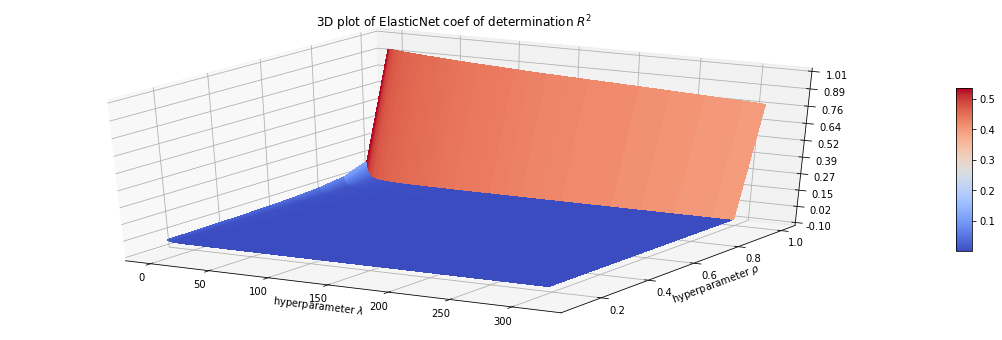

In [151]:
# ELASTIC NET

net = ElasticNet(normalize= True, random_state = 42, tol = 0.01)

N_alpha = 100
N_rho   = 10
alphaRange = np.logspace(0.1, 2.5, N_alpha)
# np.logspace(-10, 2, N_alpha)
rhoRange   = np.linspace(0.1,1, N_rho) # we avoid very small rho by starting at 0.1
scores     = np.zeros((N_rho, N_alpha))
errors     = np.zeros((N_rho, N_alpha))
for alphaIdx, alpha in enumerate(alphaRange):
    for rhoIdx, rho in enumerate(rhoRange):
        net.set_params(alpha=alpha, l1_ratio=rho)
        net.fit(X_train, Y_train)
        scores[rhoIdx, alphaIdx] = net.score(X_train, Y_train) 
        y_pred = net.predict(X_test)
        errors[rhoIdx, alphaIdx] = RSS(Y_test, y_pred)
            
fig = plt.figure(figsize=(20, 6))
ax1 = fig.gca(projection='3d')

# Make data.
X = alphaRange
Y = rhoRange
X, Y = np.meshgrid(X, Y)
Z = scores

# Plot the surface.
surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax1.set_zlim(-0.1, 1.01)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'hyperparameter $\rho$')
        
parameters = {'alpha': alphaRange,
              'normalize': [True], 
              'l1_ratio': rhoRange,
              'random_state': [42]}

netCV = GridSearchCV(net, parameters, scoring ='neg_mean_absolute_error', cv=5).fit(X_train, Y_train)
print(netCV.best_params_)
print(netCV.best_score_)

net.set_params(alpha = netCV.best_params_['alpha'], 
               l1_ratio = netCV.best_params_['l1_ratio'], normalize = True)
net.fit(X_train, Y_train)

# net_pred = net.predict(X_test)
net_train = net.predict(X_train)
net_test = net.predict(X_test)

r2.loc['ElasticNet'] = pd.Series({
                        'r2_train': net.score(X_train, Y_train),
                        'r2_test': net.score(X_test, Y_test), 
                        'MSE_train': mse(Y_train, net_train), 
                        'MSE_test': mse(Y_test, net_test),
                        'MAE_train': mae(Y_train, net_train), 
                        'MAE_test': mae(Y_test, net_test)
                    })

r2

{'criterion': 'mse', 'min_samples_split': 22, 'random_state': 42, 'splitter': 'random'}
0.7990193717792802
0.8676369684856999
0.7632244611322558


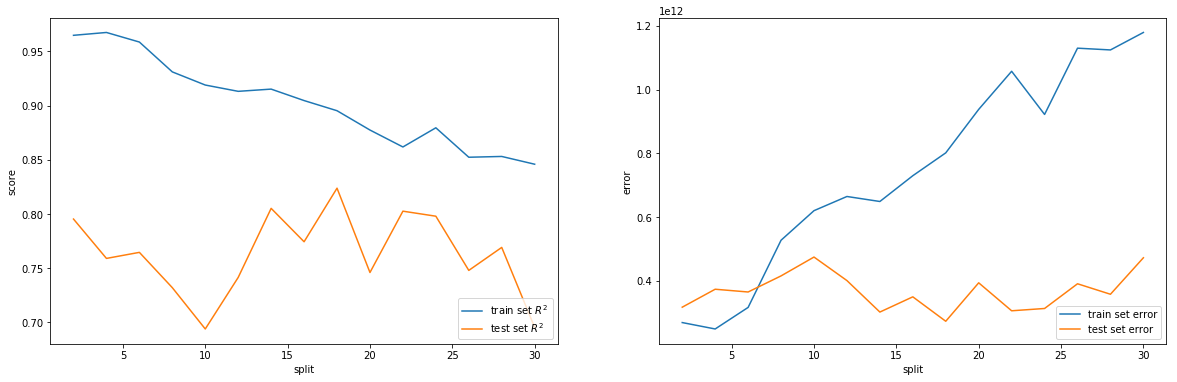

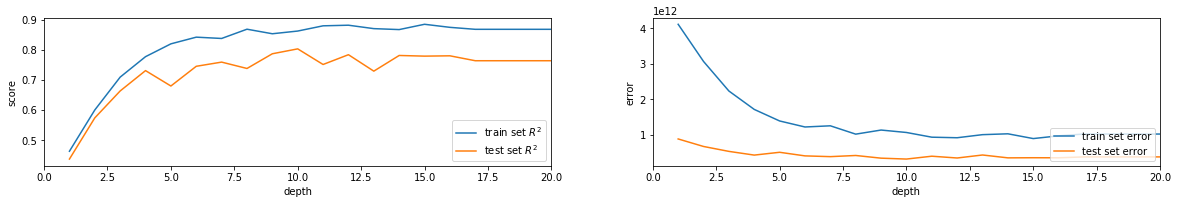

,r2_train,r2_test,MSE_train,MSE_test,MAE_train,MAE_test
Linear,0.862228,0.843184,9.044774e+08,8.330910e+08,20198.614094,21199.267657
Ridge,0.920930,0.902899,5.190947e+08,5.158543e+08,14759.202367,15455.445542
Lasso,0.912954,0.905783,5.714580e+08,5.005338e+08,15635.427218,15678.940861
ElasticNet,0.906846,0.907610,6.115606e+08,4.908275e+08,16050.560302,15704.920063
Tree,0.861867,0.802653,9.068497e+08,1.048411e+09,18924.853581,23113.092375
XGB,0.975217,0.817783,1.627040e+08,9.680330e+08,9576.023474,20537.184249


In [209]:
# TREE MODEL

#in tree based model, score is related to improvement on splits
#

# tree_model = tree.DecisionTreeRegressor(random_state=42)
# features = get_features(tree_model, X_train, Y_train)

# cols = list(islice(features.keys(), 15))

# grid_para_tree = [{
#     "criterion": ['mse', 'friedman_mse', 'mae'],
#     "splitter": ['best', 'random'],
#     "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
#     "random_state": [42]
# }]
# cv = GridSearchCV(tree_model, grid_para_tree, scoring = 'r2', cv=5)
# cv.fit(X_train[cols], Y_train)

print(cv.best_params_)
print(cv.best_score_)
print(cv.score(X_train[cols], Y_train))
print(cv.score(X_test[cols], Y_test))

split = np.linspace(start=2, stop=30, num=15, dtype=int)
train_error = []
test_error = []
e_train = []
e_test = []

for i in split:
    tree_model.set_params(min_samples_split=i, 
                          criterion=cv.best_params_['criterion'], 
                          splitter = cv.best_params_['splitter'])
    tree_model.fit(X_train[cols], Y_train)
    train_error.append(tree_model.score(X_train[cols], Y_train))
    test_error.append(tree_model.score(X_test[cols], Y_test))
    
    y_val = tree_model.predict(X_train[cols])
    y_pred = tree_model.predict(X_test[cols])
    
    e_train.append(RSS(Y_train, y_val))
    e_test.append(RSS(Y_test, y_pred))


#6, 8
plt.figure(figsize=(20, 6))

ax1 = plt.subplot(121)
ax1.plot(split, train_error, label=r'train set $R^2$')
ax1.plot(split, test_error, label=r'test set $R^2$')
plt.xlabel('split')
plt.ylabel('score')
# ax1.set_xlim([10, 25])
plt.legend(loc=4)

ax2 = plt.subplot(122)
ax2.plot(split, e_train, label=r'train set error')
ax2.plot(split, e_test, label=r'test set error')

plt.xlabel('split')
plt.ylabel('error')
# ax2.set_xlim([10, 25])
plt.legend(loc=4)

plt.show()    

depth = range(1, 50)
train_error = []
test_error = []
e_train = []
e_test = []
for i in depth:
    tree_model.set_params(max_depth=i, 
                          criterion=cv.best_params_['criterion'], 
                          min_samples_split = cv.best_params_['min_samples_split'], 
                          splitter = cv.best_params_['splitter'])
    tree_model.fit(X_train[cols], Y_train)
    train_error.append(tree_model.score(X_train[cols], Y_train))
    test_error.append(tree_model.score(X_test[cols], Y_test))
    
    y_val = tree_model.predict(X_train[cols])
    y_pred = tree_model.predict(X_test[cols])
    e_train.append(RSS(Y_train, y_val))
    e_test.append(RSS(Y_test, y_pred))
   
plt.figure(figsize=(20, 6))

ax1 = plt.subplot(221)
ax1.plot(depth, train_error, label=r'train set $R^2$')
ax1.plot(depth, test_error, label=r'test set $R^2$')
plt.xlabel('depth')
plt.ylabel('score')
ax1.set_xlim([0, 20])
plt.legend(loc=4)

ax2 = plt.subplot(222)
ax2.plot(depth, e_train, label=r'train set error')
ax2.plot(depth, e_test, label=r'test set error')

plt.xlabel('depth')
plt.ylabel('error')
ax2.set_xlim([0, 20])
plt.legend(loc=4)

plt.show()

tree_model.set_params(max_depth=10, 
                      criterion=cv.best_params_['criterion'], 
                      min_samples_split = cv.best_params_['min_samples_split'], 
                      splitter = cv.best_params_['splitter'])

tree_model.fit(X_train[cols], Y_train)

tree_train = tree_model.predict(X_train[cols])
tree_test = tree_model.predict(X_test[cols])

r2.loc['Tree'] = pd.Series({
                        'r2_train': tree_model.score(X_train[cols], Y_train),
                        'r2_test': tree_model.score(X_test[cols], Y_test), 
                        'MSE_train': mse(Y_train, tree_train), 
                        'MSE_test': mse(Y_test, tree_test),
                        'MAE_train': mae(Y_train, tree_train), 
                        'MAE_test': mae(Y_test, tree_test)
                    })

r2

{'min_samples_split': 2, 'random_state': 1}
0.8625254153204696
0.9716566268397588
0.8623522656512125


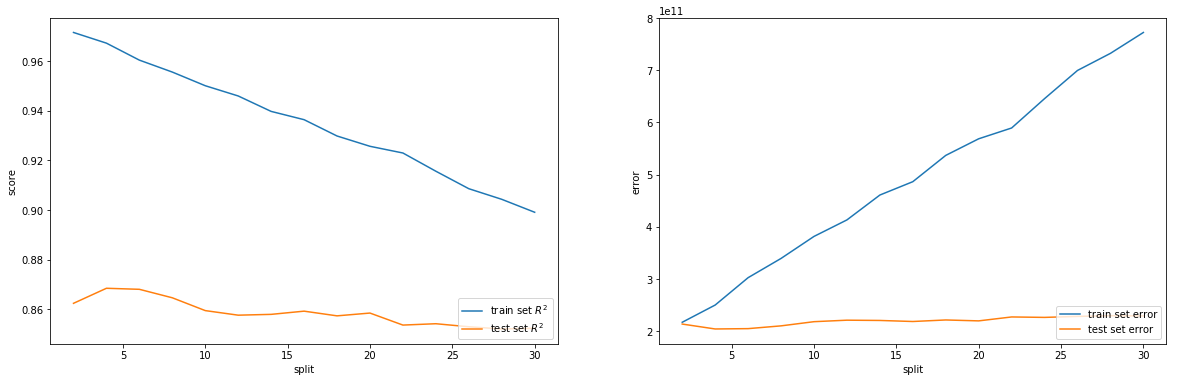

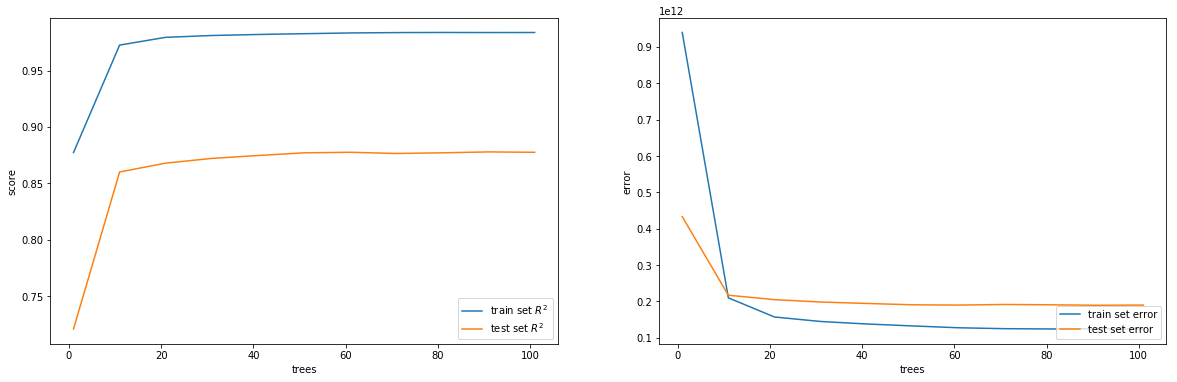

,r2_train,r2_test,MSE_train,MSE_test,MAE_train,MAE_test
Linear,0.862228,0.843184,9.044774e+08,8.330910e+08,20198.614094,21199.267657
Ridge,0.920930,0.902899,5.190947e+08,5.158543e+08,14759.202367,15455.445542
Lasso,0.912954,0.905783,5.714580e+08,5.005338e+08,15635.427218,15678.940861
ElasticNet,0.906846,0.907610,6.115606e+08,4.908275e+08,16050.560302,15704.920063
Tree,0.861867,0.802653,9.068497e+08,1.048411e+09,18924.853581,23113.092375
XGB,0.975217,0.817783,1.627040e+08,9.680330e+08,9576.023474,20537.184249
RF,0.969838,0.866891,1.980147e+08,7.071484e+08,8506.938727,17927.764460


In [243]:
# RANDOM FOREST

rf = ensemble.RandomForestRegressor(random_state=1)
features = get_features(rf, X_train, Y_train)

cols = list(islice(features.keys(), 15))

grid_para_tree = [{
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [1]
}]
cv = GridSearchCV(rf, grid_para_tree, cv=5)
cv.fit(X_train[cols], Y_train)

print(cv.best_params_)
print(cv.best_score_)
print(cv.score(X_train[cols], Y_train))
print(cv.score(X_test[cols], Y_test))

split = np.linspace(start=2, stop=30, num=15, dtype=int)
train_error2 = []
test_error2 = []
e_train = []
e_test = []

for i in split:
    rf.set_params(min_samples_split = i)
    rf.fit(X_train[cols], Y_train)
    train_error2.append(rf.score(X_train[cols], Y_train))
    test_error2.append(rf.score(X_test[cols], Y_test))
    
    y_val = rf.predict(X_train[cols])
    y_pred = rf.predict(X_test[cols])
    e_train.append(RSS(Y_train, y_val))
    e_test.append(RSS(Y_test, y_pred))

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(121)
ax1.plot(split, train_error2, label=r'train set $R^2$')
ax1.plot(split, test_error2, label=r'test set $R^2$')
plt.xlabel('split')
plt.ylabel('score')
# ax1.set_xlim([0, 20])
plt.legend(loc=4)

ax2 = plt.subplot(122)
ax2.plot(split, e_train, label=r'train set error')
ax2.plot(split, e_test, label=r'test set error')

plt.xlabel('split')
plt.ylabel('error')
# ax2.set_xlim([0, 20])
plt.legend(loc=4)

plt.show()  
    
    
n_trees_range = range(1, 110, 10)  # OOB score will warning if too few trees
train_error2 = []
test_error2 = []
e_train = []
e_test = []

for n_trees in n_trees_range:
    rf.set_params(n_estimators=n_trees, min_samples_split = cv.best_params_['min_samples_split'])
    rf.fit(X_train[cols], Y_train)
    train_error2.append(rf.score(X_train[cols], Y_train))
    test_error2.append(rf.score(X_test[cols], Y_test))
    
    y_val = rf.predict(X_train[cols])
    y_pred = rf.predict(X_test[cols])
    e_train.append(RSS(Y_train, y_val))
    e_test.append(RSS(Y_test, y_pred))
    
plt.figure(figsize=(20, 6))

ax1 = plt.subplot(121)
ax1.plot(n_trees_range, train_error2, label=r'train set $R^2$')
ax1.plot(n_trees_range, test_error2, label=r'test set $R^2$')
plt.xlabel('trees')
plt.ylabel('score')
# ax1.set_xlim([0, 30])
plt.legend(loc=4)

ax2 = plt.subplot(122)
ax2.plot(n_trees_range, e_train, label=r'train set error')
ax2.plot(n_trees_range, e_test, label=r'test set error')
# ax2.set_xlim([0, 20])
plt.xlabel('trees')
plt.ylabel('error')
plt.legend(loc=4)

plt.show()

rf.set_params(n_estimators=9, min_samples_split = cv.best_params_['min_samples_split'])
rf.fit(X_train[cols], Y_train)

rf_train = rf.predict(X_train[cols])
rf_test = rf.predict(X_test[cols])

r2.loc['RF'] = pd.Series({
                        'r2_train': rf.score(X_train[cols], Y_train),
                        'r2_test': rf.score(X_test[cols], Y_test), 
                        'MSE_train': mse(Y_train, rf_train), 
                        'MSE_test': mse(Y_test, rf_test),
                        'MAE_train': mae(Y_train, rf_train), 
                        'MAE_test': mae(Y_test, rf_test)
                    })

r2

In [244]:
# XGBOOST

import warnings
warnings.simplefilter(action='ignore', category= DeprecationWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

xgb_model = xgb.XGBRegressor(random_state=42)
get_features(xgb_model, X_train, Y_train)

cols = list(islice(features.keys(), 15))

grid_para_tree = [{
    "booster": ["gbtree", "dart"],
    'learning_rate': np.linspace(0.1, 1, 10),
    'min_child_weight':range(1, 6),
    "random_state": [42],
    "max_depth": range(1, 5)
}]

cv = GridSearchCV(xgb_model, grid_para_tree, cv = 5)
cv.fit(X_train[cols], Y_train)

print(cv.best_params_)
print(cv.best_score_)
print(cv.score(X_train[cols], Y_train))
print(cv.score(X_test[cols], Y_test))

# depth = range(5, 500)
# train_error = []
# test_error = []
# errors = []
# for i in depth:
#     xgb_model.set_params(n_estimators=i, booster= grid_search_tree.best_params_['booster'], 
#                          min_child_weight = grid_search_tree.best_params_['min_child_weight'], 
#                          learning_rate = grid_search_tree.best_params_['learning_rate'], 
#                          max_depth = grid_search_tree.best_params_['max_depth'])
#     xgb_model.fit(X_train[cols], Y_train)
#     train_error.append(xgb_model.score(X_train[cols], Y_train))
#     test_error.append(xgb_model.score(X_test[cols], Y_test))
#     y_pred = xgb_model.predict(X_test[cols])
#     errors.append(RSS(Y_test, y_pred))

# plt.figure(figsize=(20, 6))

# ax1 = plt.subplot(121)
# ax1.plot(depth, train_error, label=r'train set $R^2$')
# ax1.plot(depth, test_error, label=r'test set $R^2$')
# ax1.set_xlim([0, 100])
# ax1.set_ylim([0, 1])
# plt.xlabel('trees')
# plt.ylabel('score')
# plt.legend(loc=4)

# ax2 = plt.subplot(122)
# ax2.plot(depth, errors)
# ax2.set_xlim([0, 100])
# # ax2.set_ylim([0, 1])
# plt.xlabel('trees')
# plt.ylabel('error')

# plt.show()

# xgb_model.set_params(n_estimators=500, booster= grid_search_tree.best_params_['booster'], 
#                          min_child_weight = grid_search_tree.best_params_['min_child_weight'], 
#                          learning_rate = grid_search_tree.best_params_['learning_rate'], 
#                          max_depth = grid_search_tree.best_params_['max_depth'])
# xgb_model.fit(X_train[cols], Y_train)
    
# # xgb_pred = xgb_model.predict(X_test[cols])
# xgb_train = xgb_model.predict(X_train[cols])
# xgb_test = xgb_model.predict(X_test[cols])

# r2.loc['XGB'] = pd.Series({
#                         'r2_train': xgb_model.score(X_train[cols], Y_train),
#                         'r2_test': xgb_model.score(X_test[cols], Y_test), 
#                         'MSE_train': mse(Y_train, xgb_train), 
#                         'MSE_test': mse(Y_test, xgb_test),
#                         'MAE_train': mae(Y_train, xgb_train), 
#                         'MAE_test': mae(Y_test, xgb_test)
#                     })

# r2

#if rss train > rss test, good. if test error > train rss, overfit

[19:24:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:24:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:25:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:26:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:26:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:27:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:27:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:27:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:27:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:27:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:28:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:28:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:28:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [ ]:
preds = [lm_pred, ridge_pred, lasso_pred, net_pred, tree_pred, rf_pred, xgb_pred]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

for ax, index in zip(axes.flatten(), range(len(preds))):
    lift_df=lift_table(y, preds[index])
    n=lift_df.shape[0]
    d = pd.DataFrame(lift_df.index)
    p = list(lift_df['AveragePrediction'])#p = list(lift_df['AveragePredictionBalanced'])
    a = list(lift_df['AverageActual'])

    mean_actual=np.mean(a)
    p.reverse()
    a.reverse()

    lift=a[0]/mean_actual
    
    axe = plt.subplot(ax)
    axe.title.set_text(r2.index[index])
    axe.plot(d,p,label='Predicted',color='blue',marker='o')
    axe.plot(d,a,label='Actual',color='red',marker='d')
    axe.plot(range(1,n+1),[mean_actual]*n,'--',label='Mean',color='k',marker=None)
    plt.legend(['Predicted','Actual','Mean'])
    plt.xlabel('decile')
    plt.ylabel('Actual vs. Predicted')
    plt.text(n-2,1.2*mean_actual, 'lift = {0:.2f} '.format(lift))

plt.tight_layout(); 

r2